# XD SEGMENT GENERATOR

This notebook takes a list of traffic signal coordinates and joins it to the INRIX XD segments

Download the latest map release from: https://map-data-downloader.inrix.com/

Currently using map release 21.2

## Before proceeding, archive the old geojson file and the daily_download_segments.txt file so they can be compared when done. 

### Don't forget to update map release number in the INXRIX_XD_Downloader

In [2]:
import pandas as pd
#import pyodbc
import geopandas as gpd
#from shapely.geometry import Point, Polygon
#import xlrd
import matplotlib.pyplot as plt
#import rtree

# Import XD Segments and Signal Coordinates

In [36]:
#Import the Oregon map
path_gjs = '//scdata2/signalshar/Data_Analysis/INRIX_API/USA_Oregon.geojson'
xd_seg = gpd.read_file(path_gjs)
#xd_seg.plot(figsize=(15,15))

In [37]:
# Import signal coordinates from Signals Assets spreadsheet. Eventually add signals from other agencies too.
path = "//Scdata/Traffic Signals/Final Cabinet Prints/ODOT_Signals_Assets.xlsm"
df = pd.read_excel(path, engine='openpyxl', sheet_name='SIGNALS', header=2, usecols = "A:B, E:F")
df['Longitude'] = df['Longitude'].astype(float)
df.rename(columns={'TSSU ID':'TSSU'}, inplace = True)

#define a function to add leading 0 to TSSU
def zero(x):
    return str(0) + str(x) if len(str(x)) == 4 else str(x)
df['TSSU'] = df['TSSU'].apply(lambda x : zero(x))
df

,TSSU,District,Latitude,Longitude
0,01001,1,46.024203,-123.911675
1,01005,1,45.979187,-123.926714
2,01006,1,45.993091,-123.920618
3,01007,1,46.001504,-123.917156
4,01009,1,46.145187,-123.914213
...,...,...,...,...
1472,14036,14,44.024735,-116.947056
1473,14037,14,44.024750,-116.943451
1474,14075,14,44.024821,-117.005110
1475,14076,14,44.039957,-116.985778


In [38]:
#Convert signals to a georeferenced geodataframe
crs = {'init' : 'epsg:4326'} #coordinate reference system
points = df.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
signals = gpd.GeoDataFrame(df, crs=crs, geometry=points)
# signals.to_crs(xd_seg.crs, inplace=True) #what does this do?
#signals

C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:title={'center':'XD Segments with Traffic Signals'}>

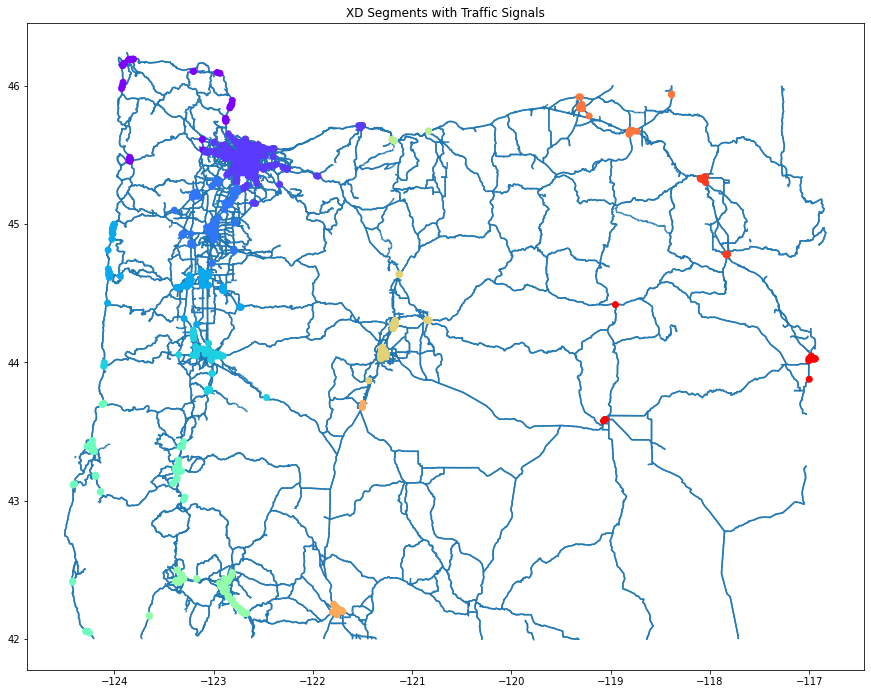

In [39]:
# Plot XD Segments and Signals together to see that it's working
fix, ax = plt.subplots(1, figsize=(15,15))
plt.title('XD Segments with Traffic Signals')
xd_seg.plot(ax=ax, zorder=0)
signals.plot(ax=ax, cmap='rainbow', column='District', zorder=10)

# Spatial Join Signals and XD Segments

Create buffer arround signal points and join them with intersections of XD segments

Then remove TSSU-XD pairs where the XD segment starts near the signal (is moving away)

In [41]:
#create buffer around each signal point
signals['geometry'] = signals['geometry'].buffer(0.0001372)
#join signal buffers to XD segments
join = gpd.sjoin(xd_seg, signals, how='inner', op='intersects')
#create uniqe identifier key for TSSU-XD pairs
join['key'] = join[['TSSU', 'XDSegID']].astype(str).agg('-'.join, axis=1)
print(join.columns.tolist())
print(len(join.index))

C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  after removing the cwd from sys.path.


['OID', 'XDSegID', 'PreviousXD', 'NextXDSegI', 'FRC', 'ToExport', 'Miles', 'Lanes', 'RoadNumber', 'RoadName', 'Country', 'State', 'County', 'PostalCode', 'SlipRoad', 'SpecialRoa', 'IsConnecto', 'AllTmcList', 'PrimaryTmc', 'RoadList', 'StartLat', 'StartLong', 'EndLat', 'EndLong', 'Bearing', 'XDGroup', 'ShapeSRID', 'geometry', 'index_right', 'TSSU', 'District', 'Latitude', 'Longitude', 'key']
8100


In [67]:
#create a copy of join to apply a negative join to remove segments where the startpoint is at the signal
#we want to see segments going towards the signal, not away from it

join_point = join[['key', 'StartLong', 'StartLat', 'TSSU']].copy()
#join_point = join_point[join_point.TSSU.isin(['03008'])] #testing by filter to mission at airport

join_point['XD_start_point'] = join_point.apply(lambda row: Point(row.StartLong, row.StartLat), axis=1) #convert XD start coords to points
join_point = join_point.set_geometry('XD_start_point')

negative = gpd.sjoin(signals, join_point, op='contains')
#This join results in adjacent signals joining to points that should be removed for them, but not their neighbors
#Thus, filter down to only where TSSU from the signal matches the XD
negative = negative[negative.TSSU_left == negative.TSSU_right]
negative


C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: None

  # Remove the CWD from sys.path while we load stuff.


,TSSU_left,District,Latitude,Longitude,geometry,index_right,key,StartLong,StartLat,TSSU_right
0,01001,1,46.024203,-123.911675,"POLYGON ((-123.91140 46.02421, -123.91140 46.0...",9937,01001-124978435,-123.91164,46.02418,01001
0,01001,1,46.024203,-123.911675,"POLYGON ((-123.91140 46.02421, -123.91140 46.0...",80713,01001-1237049569,-123.91164,46.02418,01001
2,01006,1,45.993091,-123.920618,"POLYGON ((-123.92034 45.99310, -123.92034 45.9...",51935,01006-1236865950,-123.92058,45.99310,01006
2,01006,1,45.993091,-123.920618,"POLYGON ((-123.92034 45.99310, -123.92034 45.9...",50541,01006-1236855939,-123.92058,45.99310,01006
2,01006,1,45.993091,-123.920618,"POLYGON ((-123.92034 45.99310, -123.92034 45.9...",18742,01006-385689177,-123.92058,45.99310,01006
...,...,...,...,...,...,...,...,...,...,...
1474,14075,14,44.024821,-117.005110,"POLYGON ((-117.00484 44.02483, -117.00484 44.0...",95,14075-120338393,-117.00513,44.02484,14075
1475,14076,14,44.039957,-116.985778,"POLYGON ((-116.98550 44.03996, -116.98550 44.0...",85,14076-116926056,-116.98576,44.03996,14076
1475,14076,14,44.039957,-116.985778,"POLYGON ((-116.98550 44.03996, -116.98550 44.0...",118,14076-120528091,-116.98576,44.03996,14076
1476,14077,14,44.044171,-116.979363,"POLYGON ((-116.97909 44.04418, -116.97909 44.0...",72,14077-116834889,-116.97933,44.04417,14077


In [68]:
#Now do a left outer join excluding the intersection (negative join)

#two step solution, but found a one line solution below
#dim_signals_XD = pd.merge(join, negative[['key']], on=['key'], how='outer', indicator=True)
#dim_signals_XD = dim_signals_XD[dim_signals_XD['_merge']=='left_only']

dim_signals_XD=pd.merge(join,negative[['key']],on=['key'],how="outer",indicator=True).query('_merge=="left_only"')
print(len(dim_signals_XD.index))
dim_signals_XD.head(2)

4314


,OID,XDSegID,PreviousXD,NextXDSegI,FRC,ToExport,Miles,Lanes,RoadNumber,RoadName,...,XDGroup,ShapeSRID,geometry,index_right,TSSU,District,Latitude,Longitude,key,_merge
0,6408164,116337789,NaN,NaN,5,None,0.111931,1.296,,NE GOODFELLOW ST,...,10781,4326,"LINESTRING (-116.94350 44.02635, -116.94351 44...",1473,14037,14,44.02475,-116.943451,14037-116337789,left_only
3,6520609,120916743,NaN,NaN,5,None,0.080331,1.068,,SE GOODFELLOW ST,...,123226,4326,"LINESTRING (-116.94314 44.02359, -116.94318 44...",1473,14037,14,44.02475,-116.943451,14037-120916743,left_only


# CALCULATING BASE TRAVEL TIMES
Import speed limits from TPAU. This will be used instead of "free flow speed"

There are multiple copies of XD segments, I think when there is a speed limit or AADT change within a segment. 

For now just average the speed/AADT?

In [69]:
speed_limits = pd.read_csv('//scdata2/signalshar/Data_Analysis/INRIX_API/Speed_Data/speed_limits.csv', index_col='XDSegID')
speed_limits = speed_limits.groupby('XDSegID').mean() 
#Check that all the XD ID's are unique
print(len(speed_limits.index))
print(speed_limits.index.nunique())
speed_limits.head(2)


21912
21912


,AADT,SPEED
XDSegID,,
120553168,11900.0,70.0
120615562,1400.0,65.0


In [70]:
#Join speed limits and AADT
dim_signals_XD = dim_signals_XD.merge(speed_limits, on='XDSegID', how='left')
dim_signals_XD.head(2)

,OID,XDSegID,PreviousXD,NextXDSegI,FRC,ToExport,Miles,Lanes,RoadNumber,RoadName,...,geometry,index_right,TSSU,District,Latitude,Longitude,key,_merge,AADT,SPEED
0,6408164,116337789,NaN,NaN,5,None,0.111931,1.296,,NE GOODFELLOW ST,...,"LINESTRING (-116.94350 44.02635, -116.94351 44...",1473,14037,14,44.02475,-116.943451,14037-116337789,left_only,NaN,NaN
1,6520609,120916743,NaN,NaN,5,None,0.080331,1.068,,SE GOODFELLOW ST,...,"LINESTRING (-116.94314 44.02359, -116.94318 44...",1473,14037,14,44.02475,-116.943451,14037-120916743,left_only,NaN,NaN


In [71]:
# Calculate travel time
dim_signals_XD['travel_time_minutes'] = dim_signals_XD.Miles.div(dim_signals_XD.SPEED).mul(60)
dim_signals_XD.tail(2)

,OID,XDSegID,PreviousXD,NextXDSegI,FRC,ToExport,Miles,Lanes,RoadNumber,RoadName,...,index_right,TSSU,District,Latitude,Longitude,key,_merge,AADT,SPEED,travel_time_minutes
4312,11220599,1237061436,4.488441e+08,1.236898e+09,2,None,0.507616,3.000,26,PIONEER BLVD,...,567,2C036,2,45.396314,-122.263028,2C036-1237061436,left_only,20000.0,25.0,1.218279
4313,11220902,1237061921,1.237023e+09,1.236964e+09,2,None,0.727797,3.452,26,PROCTOR BLVD,...,568,2C037,2,45.397284,-122.261537,2C037-1237061921,left_only,18100.0,25.0,1.746712


# Group XD Segments

Add a group id to each segment, using the previous/next ID columns

In [72]:
#join[['key', 'StartLong', 'StartLat']].copy()
g = dim_signals_XD[['XDSegID', 'PreviousXD', 'NextXDSegI']].copy().drop_duplicates(subset=['XDSegID', 'PreviousXD', 'NextXDSegI']).set_index('XDSegID')
g

,PreviousXD,NextXDSegI
XDSegID,,
116337789,NaN,NaN
120916743,NaN,NaN
383985787,1.187523e+09,4.289573e+08
1187436457,4.289573e+08,1.187436e+09
116342301,NaN,NaN
...,...,...
1237054664,1.236987e+09,1.236944e+09
1237054703,1.236841e+09,1.236877e+09
1237059921,4.409257e+08,3.860463e+08


In [73]:
g['group'] = ""
group = 0
l = []

for i in range(len(g)):
    x = g.index[i]
    if x not in l:
        group += 1
        p = g.PreviousXD.loc[x]
        n = g.NextXDSegI.loc[x]
        g.group.loc[x] = group
        while not pd.isnull(p):
            try:
                g.group.loc[int(p)] = group
                l.append(int(p))
                p = g.PreviousXD.loc[p]
            except: 
                break
        while not pd.isnull(n):
            try:
                g.group.loc[int(n)] = group
                l.append(int(n))
                n = g.PreviousXD.loc[n]
            except:
                break
        l.append(x)
g=g[['group']].copy()
g

C:\Users\hwyr67g\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,group
XDSegID,
116337789,1
120916743,2
383985787,3
1187436457,4
116342301,5
...,...
1237054664,634
1237054703,2706
1237059921,1204


In [74]:
#Join the group # to the dim table
dim_signals_XD = dim_signals_XD.merge(g, on='XDSegID', how='left')
dim_signals_XD.head()

,OID,XDSegID,PreviousXD,NextXDSegI,FRC,ToExport,Miles,Lanes,RoadNumber,RoadName,...,TSSU,District,Latitude,Longitude,key,_merge,AADT,SPEED,travel_time_minutes,group
0,6408164,116337789,NaN,NaN,5,None,0.111931,1.296,,NE GOODFELLOW ST,...,14037,14,44.024750,-116.943451,14037-116337789,left_only,NaN,NaN,NaN,1
1,6520609,120916743,NaN,NaN,5,None,0.080331,1.068,,SE GOODFELLOW ST,...,14037,14,44.024750,-116.943451,14037-120916743,left_only,NaN,NaN,NaN,2
2,8663597,383985787,1.187523e+09,4.289573e+08,2,None,0.422287,3.164,30,E IDAHO AVE,...,14037,14,44.024750,-116.943451,14037-383985787,left_only,23600.0,35.0,0.723921,3
3,10961771,1187436457,4.289573e+08,1.187436e+09,2,None,0.575795,3.237,30,E IDAHO AVE,...,14037,14,44.024750,-116.943451,14037-1187436457,left_only,23600.0,35.0,0.987076,4
4,6408295,116342301,NaN,NaN,5,None,0.062159,NaN,,NE 4TH ST,...,14034,14,44.025515,-116.956193,14034-116342301,left_only,NaN,NaN,NaN,5


# Save Results to Files on signalshar

In [75]:
#create unique set of XD Segment IDs for use in calling data from the API
path = '//scdata2/signalshar/Data_Analysis/INRIX_API/Speed_Data/daily_download_segments.txt'
segments = set(dim_signals_XD['XDSegID'])
with open(path, 'w') as f:
    f.write(repr(segments)[1:-1])

In [81]:
#save the signals_xd dimension file
dim_signals_XD.to_csv('//scdata2/signalshar/Data_Analysis/INRIX_API/Speed_Data/dim_signals_XD.csv', index=False)
#dim_signals_XD.to_csv('//scdata2/signalshar/Data_Analysis/Data/Performance/dim_signals_XD.csv', index=False)

In [79]:
dim_signals_XD


,OID,XDSegID,PreviousXD,NextXDSegI,FRC,ToExport,Miles,Lanes,RoadNumber,RoadName,...,TSSU,District,Latitude,Longitude,key,_merge,AADT,SPEED,travel_time_minutes,group
0,6408164,116337789,NaN,NaN,5,None,0.111931,1.296,,NE GOODFELLOW ST,...,14037,14,44.024750,-116.943451,14037-116337789,left_only,NaN,NaN,NaN,1
1,6520609,120916743,NaN,NaN,5,None,0.080331,1.068,,SE GOODFELLOW ST,...,14037,14,44.024750,-116.943451,14037-120916743,left_only,NaN,NaN,NaN,2
2,8663597,383985787,1.187523e+09,4.289573e+08,2,None,0.422287,3.164,30,E IDAHO AVE,...,14037,14,44.024750,-116.943451,14037-383985787,left_only,23600.000000,35.000000,0.723921,3
3,10961771,1187436457,4.289573e+08,1.187436e+09,2,None,0.575795,3.237,30,E IDAHO AVE,...,14037,14,44.024750,-116.943451,14037-1187436457,left_only,23600.000000,35.000000,0.987076,4
4,6408295,116342301,NaN,NaN,5,None,0.062159,NaN,,NE 4TH ST,...,14034,14,44.025515,-116.956193,14034-116342301,left_only,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,11220210,1237060543,1.255757e+08,1.236967e+09,2,None,0.969812,3.770,26,US-26,...,2C035,2,45.400374,-122.278200,2C035-1237060543,left_only,32800.000000,36.666667,1.586965,2462
4310,11220210,1237060543,1.255757e+08,1.236967e+09,2,None,0.969812,3.770,26,US-26,...,2C040,2,45.402501,-122.284288,2C040-1237060543,left_only,32800.000000,36.666667,1.586965,2462
4311,11220211,1237060545,1.237061e+09,1.236983e+09,2,None,0.576977,3.296,26,US-26,...,2C040,2,45.402501,-122.284288,2C040-1237060545,left_only,32933.333333,43.333333,0.798891,947
4312,11220599,1237061436,4.488441e+08,1.236898e+09,2,None,0.507616,3.000,26,PIONEER BLVD,...,2C036,2,45.396314,-122.263028,2C036-1237061436,left_only,20000.000000,25.000000,1.218279,432
